# Распознавание маски на лице с помощью OpenCV и глубокого обучения

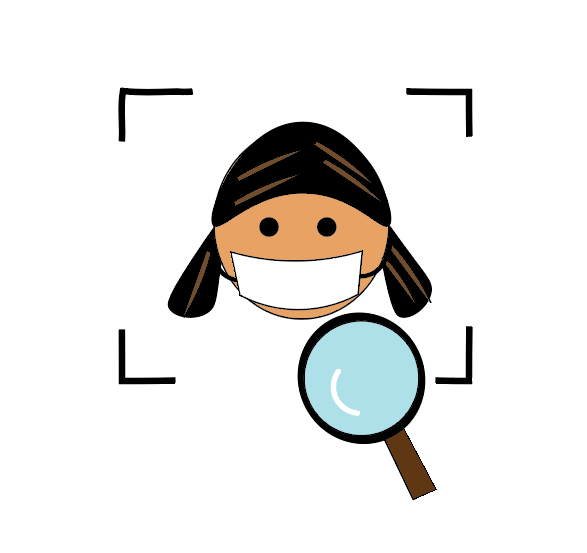

Задачу можно разбить на 2 этапа:
1. Находим лицо на фотографии
2. Классифицируем есть ли маска на лице

# 1. Распознавание лиц с помощью OpenCV

Быстрое и точное распознавание лиц с помощью OpenCV, используя предварительно обученную модель детектора лиц, поставляемую вместе с библиотекой.

Import required Python libraries

In [1]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import argparse
import os
import sys

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.12 (default, Jan 15 2022, 18:48:18) 
Numpy        : 1.21.5
Tensorflow   : 2.8.0
Keras        : 2.8.0


In [3]:
# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

Скачаем фотографию для примера (можете вставить любую свою)

In [4]:
!wget -O sample.jpg https://m.buro247.ru/images/2017/11/625-625-GettyImages-856433996.jpg

--2022-03-10 14:42:34--  https://m.buro247.ru/images/2017/11/625-625-GettyImages-856433996.jpg
Resolving m.buro247.ru (m.buro247.ru)... 89.208.156.120
Connecting to m.buro247.ru (m.buro247.ru)|89.208.156.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188207 (184K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>] 183.80K   683KB/s    in 0.3s    

2022-03-10 14:42:35 (683 KB/s) - ‘sample.jpg’ saved [188207/188207]



Читаем и измением размер изображения.    
Read, resize and display the image. 

400 400


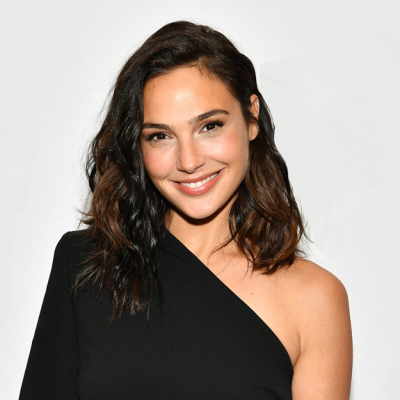

In [5]:
image = cv2.imread('sample.jpg')

# изменяем его размер до максимальной ширины 400 пикселей
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

Детектор лиц с глубоким обучением OpenCV основан на платформе Single Shot Detector (SSD) с базовой сетью ResNet. Сеть определяется и обучается с использованием фреймворка [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/)

При использовании глубокого нейросетевого модуля OpenCV с моделями Caffe вам понадобится два набора файлов:

- Файлы .prototxt, которые определяют архитектуру модели (deploy.prototxt)
- Файл .caffemodel, который содержит веса для фактических слоев (res10_300x300_ssd_iter_140000.caffemodel) 
Оба файла необходимы при использовании моделей, обученных с помощью Caffe для глубокого обучения.

Скачаем уже обученную модель детекции лица:

In [6]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2022-03-10 14:42:37--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2022-03-10 14:42:37 (12.6 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2022-03-10 14:42:37--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Загрузим уже обученную модель детекции лица с диска:

In [7]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model_w = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model_w)

[INFO] loading model...


Функция [dnn.blobFromImage](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/)  позаботится о предварительной обработке, которая включает в себя обрезку до нужного размера (300x300 pixels) для модели и нормализацию


In [8]:
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

Передадим полученные данные в сеть для предсказания

In [9]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Для удобства "Завернем" всю обработу в эту функцию чтоб нарисовать рамки вокруг обнаруженных лиц.

In [10]:
def draw_bb(image):
  '''
  функция Рисует рамки вокруг обнаруженных лиц 
  основываясь на вероятности нахождения лица в этом месте от DL модели

    Параметры:
            image : изображение
    Возвращаемое значение:
            image : итоговое изображение
  '''
  # Функция dnn.blobFromImage позаботится о предварительной обработке, 
  # которая включает в себя обрезку до нужного размера (300x300 pixels) для модели и нормализацию
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  
  # Передадим полученные данные в сеть для предсказания
  net.setInput(blob)
  detections = net.forward()

  for i in range(0, detections.shape[2]):
    # извлекаем достоверность (т.е. вероятность) нахождения лица в этом месте
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections[0, 0, i, 2]

    # отфильтровываем слабые обнаружения, убедившись, что вероятность
    # больше минимального порога достоверности (confidence > 0.5)

    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence threshold
    if confidence > 0.5:
      # вычисляем (x, y) - координаты ограничивающего прямоугольника объекта
      # compute the (x, y)-coordinates of the bounding box for the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
    
      # рисуем ограничивающую рамку лица вместе с соответствующей вероятностью
      # draw the bounding box of the face along with the associated probability
      text = "{:.2f}%".format(confidence * 100)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
      cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  return image

Смотрим получившееся изображение

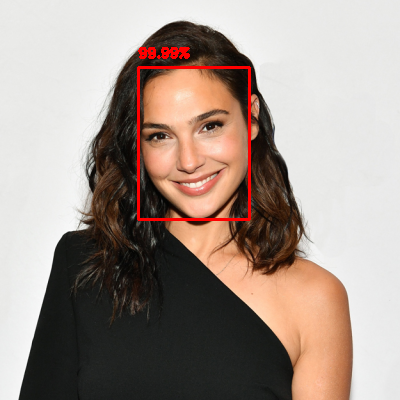

In [11]:
image_result = draw_bb(image)
cv2_imshow(image_result)

# Фото C Webcam

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Сделаем снимок с вебкамеры     
Click 'Capture' to make photo using your webcam.

In [ ]:
image_file = take_photo()

<IPython.core.display.Javascript object>

400 300


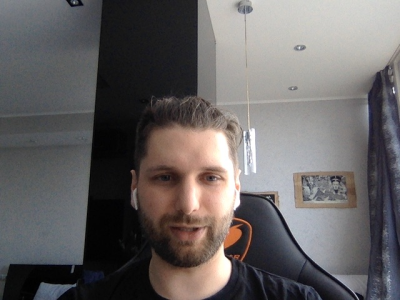

In [ ]:
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

Смотрим получившееся изображение

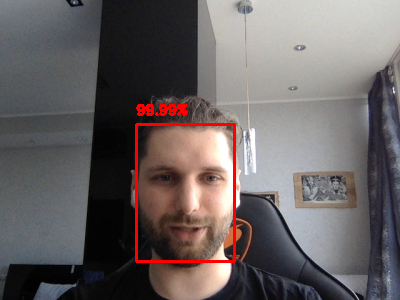

In [ ]:
image = draw_bb(image)
cv2_imshow(image)

# 2. Распознавание маски на лице
Первую задачу мы уже умеем решать, теперь потребуется модель классификатор, которая определяет наличия маски на лице.

В OpenCV под эту задачу готовой сети нету, по этому обучим свою сеть самостоятельно.

### План на модель Классификатора наличия маски:
1) Подгружаем датасет.   
2) Подгружаем предобученную сеть на imagenet.    
3) Дообучаем сеть под нашу задачу.    
4) Проверяем полученную модель.    
5) Интегрируем код модели в детектор.   

Поехали!

### 1) Скачиваем Датасет
Сбор датасета под новую задачу - это отдельная тема со множеством своих нюансов. Но я нашел уже готовый датасет в этой теме, воспользуемся им.

In [12]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 4587, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 4587 (delta 27), reused 10 (delta 3), pack-reused 4524
Receiving objects: 100% (4587/4587), 186.72 MiB | 34.06 MiB/s, done.
Resolving deltas: 100% (266/266), done.
Checking out files: 100% (4155/4155), done.


In [13]:
!ls Face-Mask-Detection/dataset/

with_mask  without_mask


### EDA
Посмотрим несколько картинок из этого датасета

Пример картинок random choices


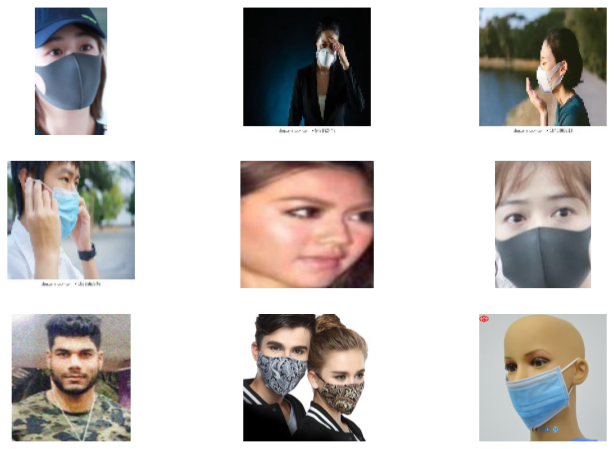

In [14]:
pathname = 'Face-Mask-Detection/dataset/'
imagePaths = list(paths.list_images(pathname))

print('Пример картинок random choices')
plt.figure(figsize=(12,8))

for index, img_name in enumerate(random.choices(imagePaths, k=9)):
    im = PIL.Image.open(img_name)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.axis('off')
plt.show()

Проверим распределение классов

In [15]:
with_mask = len(list(paths.list_images(pathname+'with_mask')))
without_mask = len(list(paths.list_images(pathname+'without_mask')))
print(f'with_mask:{with_mask} vs without_mask:{without_mask}')

with_mask:2162 vs without_mask:1930


### SETUP MODEL
настройка модели

In [38]:
CLASS_NUM            = 2  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

DATA_PATH = 'Face-Mask-Detection/dataset/'

### Подгружаем картинки
мы не можем загрузить сразу все картинки для обучения, нам не хватит памяти. Поэтому используем специальный генератор который передает в обучение наборами (BATCH)

In [39]:
# data generator for training set
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = VAL_SPLIT, # set validation split
    )

In [40]:
# generator for reading train data from folder
train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

# generator for reading validation data from folder
test_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 3479 images belonging to 2 classes.
Found 613 images belonging to 2 classes.


### 2) Подгружаем предобученную сеть на imagenet.
название модели MobileNetV2 и обучена она на датасете imagenet

In [41]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

Изменим выходной слой (голову) под нашу задачу

In [42]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(CLASS_NUM, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [43]:
# compile our model
print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=LR), metrics=["accuracy"])

[INFO] compiling model...


In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

### 3) Дообучаем сеть под нашу задачу.

In [45]:
history = model.fit(
        train_generator,
        validation_data = test_generator, 
        epochs = EPOCHS,
  )

Epoch 1/10
55/55 [==============================] - 49s 777ms/step - loss: 0.1432 - accuracy: 0.9416 - val_loss: 0.5064 - val_accuracy: 0.8662
Epoch 2/10
55/55 [==============================] - 41s 749ms/step - loss: 0.0067 - accuracy: 0.9989 - val_loss: 0.1677 - val_accuracy: 0.9445
Epoch 3/10
55/55 [==============================] - 42s 753ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1530 - val_accuracy: 0.9494
Epoch 4/10
55/55 [==============================] - 42s 759ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.1491 - val_accuracy: 0.9511
Epoch 5/10
55/55 [==============================] - 42s 753ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.1250 - val_accuracy: 0.9657
Epoch 6/10
55/55 [==============================] - 41s 747ms/step - loss: 8.5329e-04 - accuracy: 1.0000 - val_loss: 0.1723 - val_accuracy: 0.9462
Epoch 7/10
55/55 [==============================] - 42s 750ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0350 - val_accuracy: 0.

In [46]:
# сохраним итоговую сеть
model.save('mask_model.hdf5')

### 4) Проверяем полученную модель.
Смотрим результаты по метрикам

In [47]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

10/10 [==============================] - 2s 162ms/step - loss: 0.0187 - accuracy: 0.9951
Accuracy: 99.51%


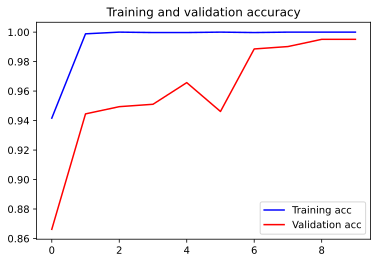

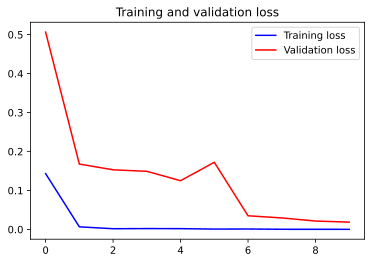

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### 5) Интегрируем код модели в детектор.
для этого отредактируем нашу функцию добавив детекцию маски после лица

In [49]:
def draw_bb(image):
  '''
  функция детектирует наличие маски на лице

      Параметры:
            image : изображение
    Возвращаемое значение:
            image : итоговое изображение
  '''
  # Функция dnn.blobFromImage позаботится о предварительной обработке, 
  # которая включает в себя обрезку до нужного размера (300x300 pixels) для модели и нормализацию
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  
  # Передадим полученные данные в сеть для предсказания
  net.setInput(blob)
  detections = net.forward()

  for i in range(0, detections.shape[2]):
    # извлекаем достоверность (т.е. вероятность) нахождения лица в этом месте
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections[0, 0, i, 2]

    # отфильтровываем слабые обнаружения, убедившись, что вероятность
    # больше минимального порога достоверности (confidence > 0.5)

    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence threshold
    if confidence > 0.5:
        # вычисляем (x, y) - координаты ограничивающего прямоугольника объекта
        # compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        ############ добавили вот этот кусок кода ##########################
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        # pass the face through the model to determine if the face
        # has a mask or not
        model = tf.keras.models.load_model('mask_model.hdf5')
        (mask, withoutMask) = model.predict(face)[0]

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        ####################################################################

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

  return image

Смотрим получившееся изображение

400 400


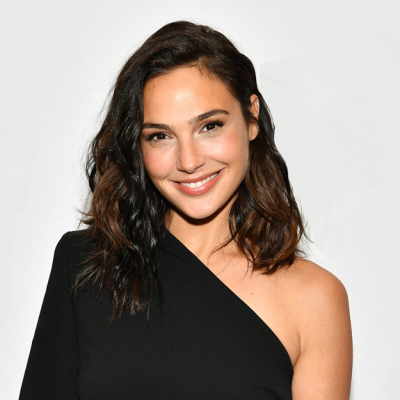

In [50]:
image = cv2.imread('sample.jpg')

# изменяем его размер до максимальной ширины 400 пикселей
# resize it to have a maximum width of 400 pixels
image_resize = imutils.resize(image, width=400)
(h, w) = image_resize.shape[:2]
print(w,h)
cv2_imshow(image_resize)

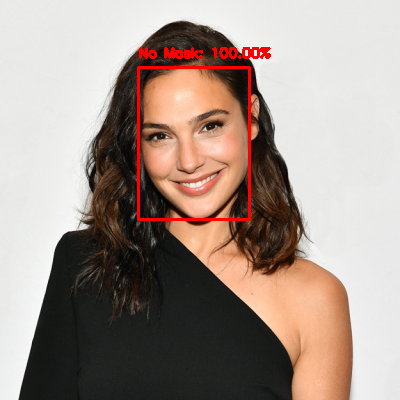

In [55]:
image_result = draw_bb(image_resize)
cv2_imshow(image_result)

давайте скачаем изображение с маской

In [52]:
!wget -O mask_sample.jpg https://i.pinimg.com/564x/cd/7c/5e/cd7c5ec4a8ee9e0aca4e3fbc828e73ba.jpg

--2022-03-10 15:05:52--  https://i.pinimg.com/564x/cd/7c/5e/cd7c5ec4a8ee9e0aca4e3fbc828e73ba.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.4.248.196, 2600:1407:3c00:148d::1931, 2600:1407:3c00:1481::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.4.248.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24345 (24K) [image/jpeg]
Saving to: ‘mask_sample.jpg’

mask_sample.jpg     100%[===================>]  23.77K  --.-KB/s    in 0.002s  

2022-03-10 15:05:53 (11.9 MB/s) - ‘mask_sample.jpg’ saved [24345/24345]



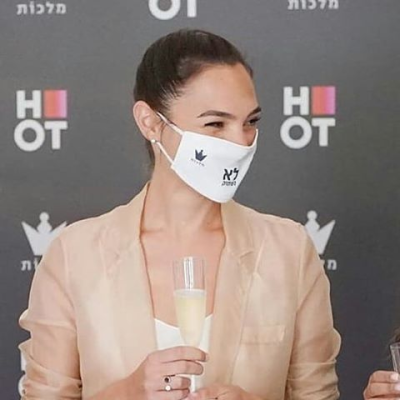

In [53]:
image_2 = cv2.imread('mask_sample.jpg')
image_2_resize = imutils.resize(image_2, width=400)
cv2_imshow(image_2_resize)

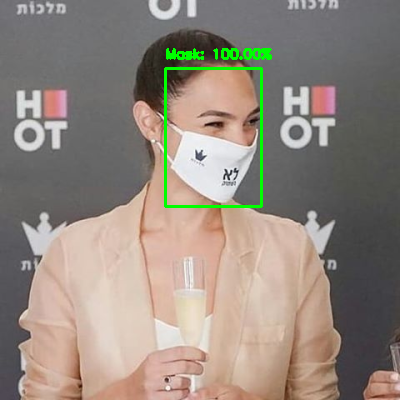

In [56]:
image_result = draw_bb(image_2_resize)
cv2_imshow(image_result)

# Фото C Webcam

In [ ]:
image_file = take_photo()

<IPython.core.display.Javascript object>

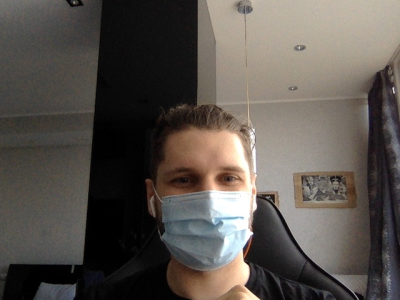

In [ ]:
image = cv2.imread(image_file)
image = imutils.resize(image, width=400)
cv2_imshow(image)

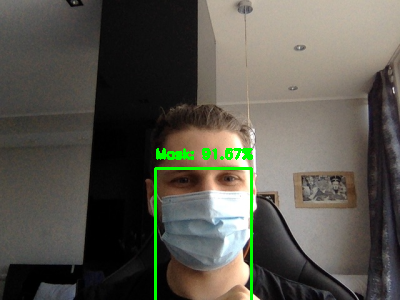

In [ ]:
image_result = draw_bb(image)
cv2_imshow(image_result)

# APP
https://face-mask--detection-app.herokuapp.com/